# Zee5 Recommender System

#### MOVIES FILE DESCRIPTION
================================================================================

Movie information is in the file "movies.dat" and is in the following
format:

MovieID::Title::Genres

- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the following genres:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western

### RATINGS FILE DESCRIPTION
================================================================================
​

All ratings are contained in the file "ratings.dat" and are in the
following format:
​
UserID::MovieID::Rating::Timestamp
​
- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds
- Each user has at least 20 ratings


#### USERS FILE DESCRIPTION
================================================================================

User information is in the file "users.dat" and is in the following
format:

UserID::Gender::Age::Occupation::Zip-code

All demographic information is provided voluntarily by the users and is
not checked for accuracy.  
Only users who have provided some demographic
information are included in this data set.

- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges:

	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"

- Occupation is chosen from the following choices:

	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"

# Import Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict 
from scipy import sparse
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import warnings
from cmfrec import CMF
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [2]:
# Setting options

warnings.simplefilter('ignore')
pd.set_option("display.max_columns", None)
pd.options.display.float_format = '{:.2f}'.format
sns.set_style('white')

# Read Data 

In [3]:


movies=pd.read_csv('zee-movies.dat', encoding='ISO-8859-1',delimiter='::',engine='python')

ratings=pd.read_csv('zee-ratings.dat', encoding='ISO-8859-1',delimiter='::',engine='python')

users=pd.read_csv('zee-users (2).dat', encoding='ISO-8859-1',delimiter='::',engine='python')

### Movies 

In [4]:
movies.rename(columns={'Movie ID':'MovieID'}, inplace=True)
movies1=movies.copy()
# movies['Title'] = movies['Title'].apply(lambda x: x.strip())

movies.head(5)

MovieID                               Title                        Genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy

### Ratings

In [5]:
ratings1=ratings.copy()
ratings.head()

UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291

### Users

In [6]:
users

UserID Gender  Age  Occupation Zip-code
0          1      F    1          10    48067
1          2      M   56          16    70072
2          3      M   25          15    55117
3          4      M   45           7    02460
4          5      M   25          20    55455
...      ...    ...  ...         ...      ...
6035    6036      F   25          15    32603
6036    6037      F   45           1    76006
6037    6038      F   56           1    14706
6038    6039      F   45           0    01060
6039    6040      M   25           6    11106

[6040 rows x 5 columns]

In [7]:
users1=users.copy()

In [8]:
users.replace({'Age':{'1':  "Under 18",
                      '18':  "18-24",
                      '25':  "25-34",
                      '35':  "35-44",
                      '45':  "45-49",
                      '50':  "50-55",
                      '56':  "56 Above"}}, inplace=True)

In [9]:
users.replace({'Occupation':{'0': "other",
                             '1': "academic/educator",
                             '2': "artist",
                             '3': "clerical/admin",
                             '4': "college/grad student",
                             '5': "customer service",
                             '6': "doctor/health care",
                             '7': "executive/managerial",
                             '8': "farmer",
                             '9': "homemaker",
                             '10': "k-12 student",
                             '11': "lawyer",
                             '12': "programmer",
                             '13': "retired",
                             '14': "sales/marketing",
                             '15': "scientist",
                             '16': "self-employed",
                             '17': "technician/engineer",
                             '18': "tradesman/craftsman",
                             '19': "unemployed",
                             '20': "writer"}}, inplace=True)

In [10]:
print(users.shape)
users.head()

(6040, 5)


UserID Gender  Age  Occupation Zip-code
0       1      F    1          10    48067
1       2      M   56          16    70072
2       3      M   25          15    55117
3       4      M   45           7    02460
4       5      M   25          20    55455

# Exploratory Data Analysis 

In [11]:
#Using regular expressions to find a year stored between parentheses
#We specify the parantheses so we don't conflict with movies that have years in their titles
movies['year'] = movies.Title.str.extract('(\(\d\d\d\d\))',expand=False)
#Removing the parentheses
movies['year'] = movies.year.str.extract('(\d\d\d\d)',expand=False)
# # #Removing the years from the 'Title' column
movies['Title'] = movies['Title'].str.replace(r'\(\d{4}\)', '', regex=True)

# # #Applying the strip function to get rid of any ending whitespace characters that may have appeared

movies['Title'] = movies.apply(lambda row: row['Title'].strip() if not pd.isna(row['Title']) else np.nan, axis=1)


movies.head()

MovieID                        Title                        Genres  year
0        1                    Toy Story   Animation|Children's|Comedy  1995
1        2                      Jumanji  Adventure|Children's|Fantasy  1995
2        3             Grumpier Old Men                Comedy|Romance  1995
3        4            Waiting to Exhale                  Comedy|Drama  1995
4        5  Father of the Bride Part II                        Comedy  1995

In [12]:
dfmov=movies.copy()
dfmov.Genres = dfmov.Genres.str.split('|')


In [13]:
df_1 = pd.merge(dfmov, ratings, how='inner', on='MovieID')
df_1.head()

MovieID      Title                           Genres  year  UserID  Rating  \
0        1  Toy Story  [Animation, Children's, Comedy]  1995       1       5   
1        1  Toy Story  [Animation, Children's, Comedy]  1995       6       4   
2        1  Toy Story  [Animation, Children's, Comedy]  1995       8       4   
3        1  Toy Story  [Animation, Children's, Comedy]  1995       9       5   
4        1  Toy Story  [Animation, Children's, Comedy]  1995      10       5   

   Timestamp  
0  978824268  
1  978237008  
2  978233496  
3  978225952  
4  978226474

In [14]:
data = pd.merge(df_1, users, how='inner', on='UserID')
data.head()

MovieID                               Title  \
0        1                           Toy Story   
1       48                          Pocahontas   
2      150                           Apollo 13   
3      260  Star Wars: Episode IV - A New Hope   
4      527                    Schindler's List   

                                      Genres  year  UserID  Rating  Timestamp  \
0            [Animation, Children's, Comedy]  1995       1       5  978824268   
1  [Animation, Children's, Musical, Romance]  1995       1       5  978824351   
2                                    [Drama]  1995       1       5  978301777   
3       [Action, Adventure, Fantasy, Sci-Fi]  1977       1       4  978300760   
4                               [Drama, War]  1993       1       5  978824195   

  Gender  Age  Occupation Zip-code  
0      F    1          10    48067  
1      F    1          10    48067  
2      F    1          10    48067  
3      F    1          10    48067  
4      F    1          10    48067

In [15]:
print("No. of rows: ", data.shape[0])
print("No. of columns: ", data.shape[1])

No. of rows:  1000209
No. of columns:  11


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 11 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   MovieID     1000209 non-null  int64 
 1   Title       1000209 non-null  object
 2   Genres      1000209 non-null  object
 3   year        1000209 non-null  object
 4   UserID      1000209 non-null  int64 
 5   Rating      1000209 non-null  int64 
 6   Timestamp   1000209 non-null  int64 
 7   Gender      1000209 non-null  object
 8   Age         1000209 non-null  int64 
 9   Occupation  1000209 non-null  int64 
 10  Zip-code    1000209 non-null  object
dtypes: int64(6), object(5)
memory usage: 83.9+ MB


In [17]:
data.isnull().sum()

MovieID       0
Title         0
Genres        0
year          0
UserID        0
Rating        0
Timestamp     0
Gender        0
Age           0
Occupation    0
Zip-code      0
dtype: int64

no missing values in the dataset

## Feature Engineering

In [18]:
data['Datetime'] = pd.to_datetime(data['Timestamp'], unit='s') #Change the datatype from object to date_time
data['year']=data['year'].astype(int) #Change the datatype from object to Integer
data['Rating']=data['Rating'].astype(int) #Change the datatype from object to Integer

In [19]:
data['Title'] =data['Title'].apply(lambda x: x.strip())

In [20]:
data['Datetime'] = pd.to_datetime(data['Timestamp'], unit='s') #Change the datatype from object to date_time
data['year']=data['year'].astype('int32') #Change the datatype from object to Integer
data['Rating']=data['Rating'].astype('int32') #Change the datatype from object to Integer

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 12 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   MovieID     1000209 non-null  int64         
 1   Title       1000209 non-null  object        
 2   Genres      1000209 non-null  object        
 3   year        1000209 non-null  int32         
 4   UserID      1000209 non-null  int64         
 5   Rating      1000209 non-null  int32         
 6   Timestamp   1000209 non-null  int64         
 7   Gender      1000209 non-null  object        
 8   Age         1000209 non-null  int64         
 9   Occupation  1000209 non-null  int64         
 10  Zip-code    1000209 non-null  object        
 11  Datetime    1000209 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(2), int64(5), object(4)
memory usage: 83.9+ MB


we have 1 datetime, 2 integer and 9 object data type columns

In [23]:
bins = [1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 2000]
labels = ['20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s']
data['ReleaseDec'] = pd.cut(data['year'], bins=bins, labels=labels)


In [24]:
data.head()

MovieID                               Title  \
0        1                           Toy Story   
1       48                          Pocahontas   
2      150                           Apollo 13   
3      260  Star Wars: Episode IV - A New Hope   
4      527                    Schindler's List   

                                      Genres  year  UserID  Rating  Timestamp  \
0            [Animation, Children's, Comedy]  1995       1       5  978824268   
1  [Animation, Children's, Musical, Romance]  1995       1       5  978824351   
2                                    [Drama]  1995       1       5  978301777   
3       [Action, Adventure, Fantasy, Sci-Fi]  1977       1       4  978300760   
4                               [Drama, War]  1993       1       5  978824195   

  Gender  Age  Occupation Zip-code            Datetime ReleaseDec  
0      F    1          10    48067 2001-01-06 23:37:48        90s  
1      F    1          10    48067 2001-01-06 23:39:11        90s  
2      F    1          10    48067 2000-12-31 22:29:37        90s  
3      F    1          10    48067 2000-12-31 22:12:40        70s  
4      F    1          10    48067 2001-01-06 23:36:35        90s

# Understanding the Dataset

#### Average User Ratings

In [25]:
user_ratings =data[['UserID','Rating']].groupby('UserID').mean()
user_ratings

Rating
UserID        
1         4.19
2         3.71
3         3.90
4         4.19
5         3.15
...        ...
6036      3.30
6037      3.72
6038      3.80
6039      3.88
6040      3.58

[6040 rows x 1 columns]

Text(0, 0.5, 'Frequency')

<Figure size 800x800 with 0 Axes>

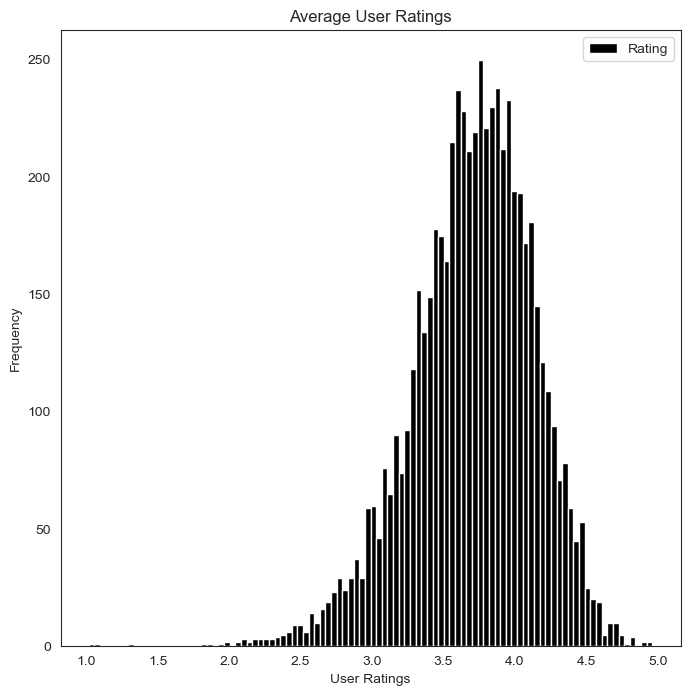

In [26]:
fig = plt.figure(figsize = (8,8))
user_ratings.plot(kind = 'hist', bins = 100, figsize = (8,8), color = 'black')
plt.plot()
plt.xlabel('User Ratings')
plt.title('Average User Ratings')
plt.ylabel('Frequency')

From above plot, we can see that on average, users are rating movies 3.5-4 more frequently than any other rating. This makes sense since people are less inclined to rate movies lower than a 3 if they didn't enjoy the movie.

#### No.of movies by Release year

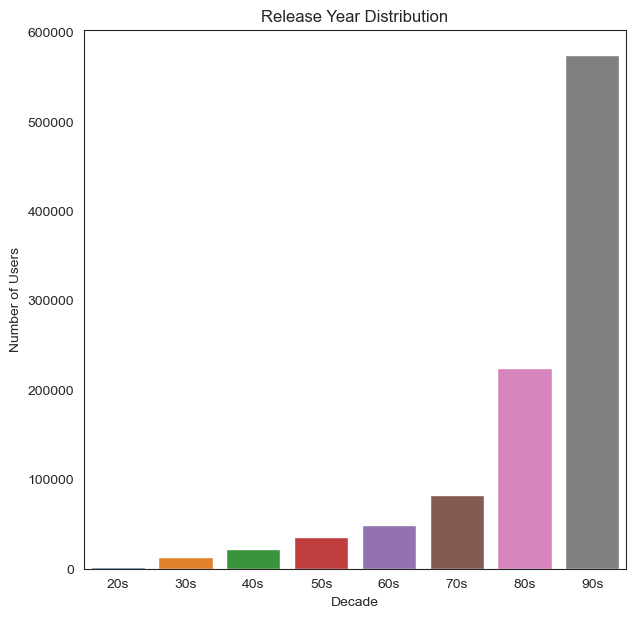

In [27]:
plt.figure(figsize=(7, 7))
sns.countplot(x='ReleaseDec', data=data)
plt.title('Release Year Distribution')
plt.xlabel('Decade')
plt.ylabel('Number of Users')
plt.show()

From the above plot we can infer most of the movies present in the dataset were released in the year 90s.

In [28]:
l = dfmov.Genres.iloc[:5]

In [29]:
pd.get_dummies(l.apply(pd.Series).stack()).sum()

Adventure     1
Animation     1
Children's    2
Comedy        4
Drama         1
Fantasy       1
Romance       1
dtype: int64

In [30]:
pd.Series(l.iloc[0])

0     Animation
1    Children's
2        Comedy
dtype: object

In [31]:
dfmov.head(2)

MovieID      Title                            Genres  year
0        1  Toy Story   [Animation, Children's, Comedy]  1995
1        2    Jumanji  [Adventure, Children's, Fantasy]  1995

#### Top 10 Genres based on movies coun

In [32]:
genres_df = pd.get_dummies(dfmov['Genres'].apply(pd.Series).stack()).sum()
genres_df.head()

Action         503
Adventure      283
Animation      105
Children's     251
Comedy        1200
dtype: int64

In [ ]:
# ### considering only the genre columns for the test
# test = genres_df.iloc[:,0:].sum()
# test=test.iloc[1:]
# print(test)

In [ ]:
# genre_list=['action', 'adventure','animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama','fantasy', 'film-noir', 'horror', 'musical', 'mystery', 'romance', 'sci-fi','thriller', 'war', 'western']
# x = np.arange(18)
# plt.figure(figsize = (10,5))
# plt.bar(x, test2, color = 'g')
# plt.xticks(x, genre_list, rotation = 'vertical')
# plt.xlabel('Genre')
# plt.ylabel('Number of Movies')
# plt.title('Movies per Genre')
# sns.set(font_scale=1.5)
# plt.show()

#### Distribution by Age

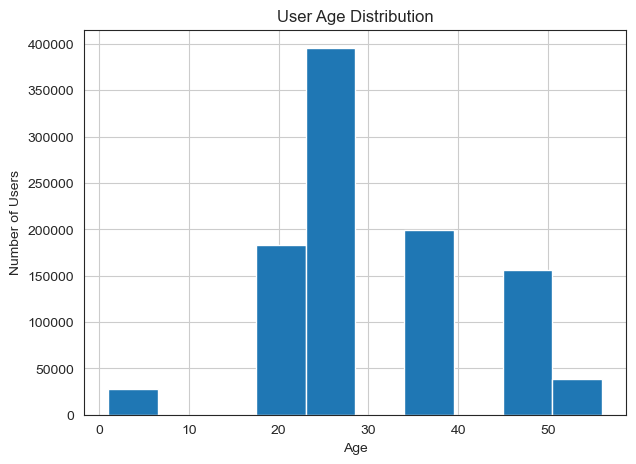

In [33]:
data['Age'].hist(figsize=(7, 5))
plt.title('User Age Distribution')
plt.xlabel('Age')
plt.ylabel('Number of Users')
plt.show()

#### From the above plot we can infer that 25-34 age group have watched and rated the most number of movies

#### Distribution by Gender -

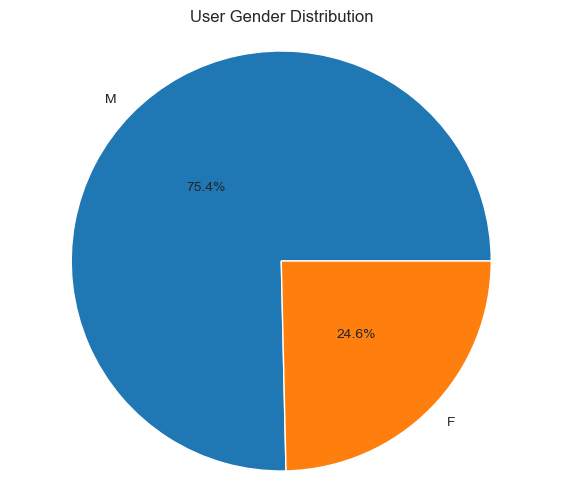

In [34]:
x = data['Gender'].value_counts().values
plt.figure(figsize=(7, 6))
plt.pie(x, center=(0, 0), radius=1.5, labels=['M','F'], autopct='%1.1f%%', pctdistance=0.5)
plt.title('User Gender Distribution')
plt.axis('equal')
plt.show()

From the above plot most of the users in our dataset who’ve rated the movies are Male.

#### Distribution by Occupation -

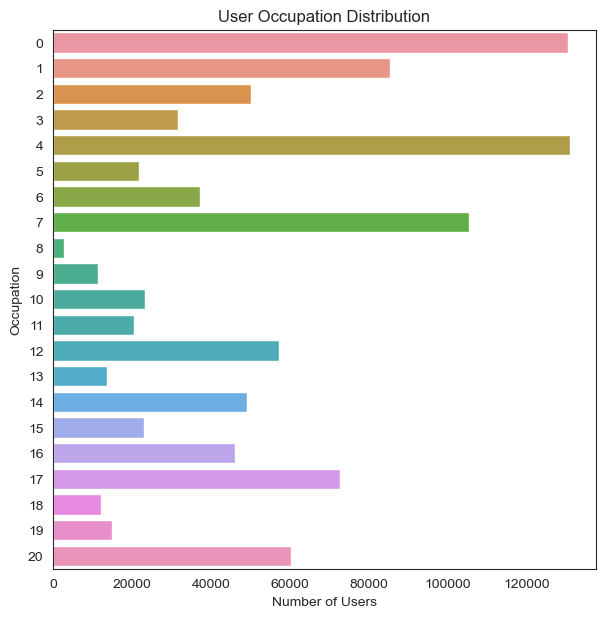

In [35]:
plt.figure(figsize=(7, 7))
sns.countplot(y='Occupation', data=data)
plt.title('User Occupation Distribution')
plt.xlabel('Number of Users')
plt.ylabel('Occupation')
plt.show()

#### From the above plot users belonging to college/grad student profession have watched and rated the most movies.

In [36]:
movies_rating_count = data.groupby(by = ['Title'])['Rating'].count().reset_index() #[['Title', 'Rating']] ## Counting the ratings based on movies
movies_rating_count

Title  Rating
0                         $1,000,000 Duck      37
1                           'Night Mother      70
2                      'Til There Was You      52
3                             'burbs, The     303
4                  ...And Justice for All     199
...                                   ...     ...
3659                 Zed & Two Noughts, A      29
3660                          Zero Effect     301
3661  Zero Kelvin (Kjærlighetens kjøtere)       2
3662                     Zeus and Roxanne      23
3663                             eXistenZ     410

[3664 rows x 2 columns]

In [37]:
movies_rating_count.rename(columns = {'Rating': 'totalRatingCount'},inplace=True)
movies_rating_count

Title  totalRatingCount
0                         $1,000,000 Duck                37
1                           'Night Mother                70
2                      'Til There Was You                52
3                             'burbs, The               303
4                  ...And Justice for All               199
...                                   ...               ...
3659                 Zed & Two Noughts, A                29
3660                          Zero Effect               301
3661  Zero Kelvin (Kjærlighetens kjøtere)                 2
3662                     Zeus and Roxanne                23
3663                             eXistenZ               410

[3664 rows x 2 columns]

In [38]:
top10_movies=movies_rating_count[['Title', 'totalRatingCount']].sort_values(by = 'totalRatingCount',ascending = False).head(10)
top10_movies

Title  totalRatingCount
126                                  American Beauty              3428
3117              Star Wars: Episode IV - A New Hope              2991
3118  Star Wars: Episode V - The Empire Strikes Back              2990
3119      Star Wars: Episode VI - Return of the Jedi              2883
1773                                   Jurassic Park              2672
2860                             Saving Private Ryan              2653
3257                      Terminator 2: Judgment Day              2649
2089                                     Matrix, The              2590
257                               Back to the Future              2583
2954                       Silence of the Lambs, The              2578

Text(0, 0.5, 'User Rating count')

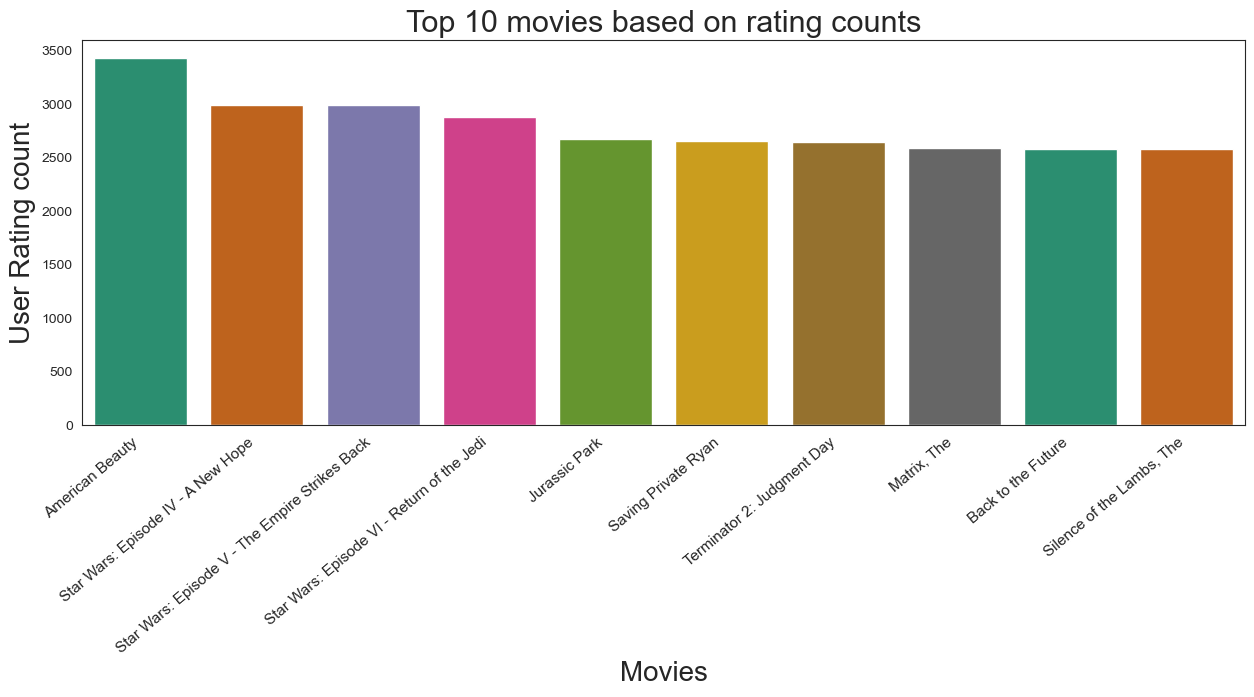

In [39]:
plt.figure(figsize=(15,5))
ax=sns.barplot(x="Title", y="totalRatingCount", data=top10_movies, palette="Dark2")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11, rotation=40, ha="right")
ax.set_title('Top 10 movies based on rating counts',fontsize = 22)
ax.set_xlabel('Movies',fontsize = 20) 
ax.set_ylabel('User Rating count', fontsize = 20)

From the above plot, the movie with maximum number of ratings is American Beauty.

# Recommendations systems

#### User-Interaction Matrix

Creating a pivot table of movie titles and userid and ratings are taken as values.

In [40]:
data

MovieID                               Title  \
0              1                           Toy Story   
1             48                          Pocahontas   
2            150                           Apollo 13   
3            260  Star Wars: Episode IV - A New Hope   
4            527                    Schindler's List   
...          ...                                 ...   
1000204     3513                 Rules of Engagement   
1000205     3535                     American Psycho   
1000206     3536                   Keeping the Faith   
1000207     3555                               U-571   
1000208     3578                           Gladiator   

                                            Genres  year  UserID  Rating  \
0                  [Animation, Children's, Comedy]  1995       1       5   
1        [Animation, Children's, Musical, Romance]  1995       1       5   
2                                          [Drama]  1995       1       5   
3             [Action, Adventure, Fantasy, Sci-Fi]  1977       1       4   
4                                     [Drama, War]  1993       1       5   
...                                            ...   ...     ...     ...   
1000204                          [Drama, Thriller]  2000    5727       4   
1000205                 [Comedy, Horror, Thriller]  2000    5727       2   
1000206                          [Comedy, Romance]  2000    5727       5   
1000207                         [Action, Thriller]  2000    5727       3   
1000208                            [Action, Drama]  2000    5727       5   

         Timestamp Gender  Age  Occupation Zip-code            Datetime  \
0        978824268      F    1          10    48067 2001-01-06 23:37:48   
1        978824351      F    1          10    48067 2001-01-06 23:39:11   
2        978301777      F    1          10    48067 2000-12-31 22:29:37   
3        978300760      F    1          10    48067 2000-12-31 22:12:40   
4        978824195      F    1          10    48067 2001-01-06 23:36:35   
...            ...    ...  ...         ...      ...                 ...   
1000204  958489970      M   25           4    92843 2000-05-16 15:12:50   
1000205  958489970      M   25           4    92843 2000-05-16 15:12:50   
1000206  958489902      M   25           4    92843 2000-05-16 15:11:42   
1000207  958490699      M   25           4    92843 2000-05-16 15:24:59   
1000208  958490171      M   25           4    92843 2000-05-16 15:16:11   

        ReleaseDec  
0              90s  
1              90s  
2              90s  
3              70s  
4              90s  
...            ...  
1000204        90s  
1000205        90s  
1000206        90s  
1000207        90s  
1000208        90s  

[1000209 rows x 13 columns]

In [41]:
matrix=pd.pivot_table(data,values='Rating',index='UserID',columns='Title')
matrix.fillna(0, inplace=True) # Imputing 'NaN' values with Zero rating 

print(matrix.shape)

matrix.head(10)

(6040, 3664)


Title   $1,000,000 Duck  'Night Mother  'Til There Was You  'burbs, The  \
UserID                                                                    
1                  0.00           0.00                0.00         0.00   
2                  0.00           0.00                0.00         0.00   
3                  0.00           0.00                0.00         0.00   
4                  0.00           0.00                0.00         0.00   
5                  0.00           0.00                0.00         0.00   
6                  0.00           0.00                0.00         0.00   
7                  0.00           0.00                0.00         0.00   
8                  0.00           0.00                0.00         0.00   
9                  0.00           0.00                0.00         0.00   
10                 0.00           0.00                0.00         4.00   

Title   ...And Justice for All  1-900  10 Things I Hate About You  \
UserID                                                              
1                         0.00   0.00                        0.00   
2                         0.00   0.00                        0.00   
3                         0.00   0.00                        0.00   
4                         0.00   0.00                        0.00   
5                         0.00   0.00                        0.00   
6                         0.00   0.00                        0.00   
7                         0.00   0.00                        0.00   
8                         0.00   0.00                        0.00   
9                         0.00   0.00                        0.00   
10                        0.00   0.00                        0.00   

Title   101 Dalmatians  12 Angry Men  13th Warrior, The  187  \
UserID                                                         
1                 0.00          0.00               0.00 0.00   
2                 0.00          0.00               0.00 0.00   
3                 0.00          0.00               0.00 0.00   
4                 0.00          0.00               0.00 0.00   
5                 0.00          0.00               0.00 0.00   
6                 0.00          0.00               0.00 0.00   
7                 0.00          0.00               0.00 0.00   
8                 0.00          0.00               0.00 0.00   
9                 0.00          0.00               0.00 0.00   
10                0.00          3.00               4.00 0.00   

Title   2 Days in the Valley  20 Dates  20,000 Leagues Under the Sea  \
UserID                                                                 
1                       0.00      0.00                          0.00   
2                       0.00      0.00                          0.00   
3                       0.00      0.00                          0.00   
4                       0.00      0.00                          0.00   
5                       0.00      0.00                          0.00   
6                       0.00      0.00                          0.00   
7                       0.00      0.00                          0.00   
8                       0.00      0.00                          0.00   
9                       0.00      0.00                          0.00   
10                      0.00      0.00                          4.00   

Title   200 Cigarettes  2001: A Space Odyssey  2010  24 7: Twenty Four Seven  \
UserID                                                                         
1                 0.00                   0.00  0.00                     0.00   
2                 0.00                   0.00  0.00                     0.00   
3                 0.00                   0.00  0.00                     0.00   
4                 0.00                   0.00  0.00                     0.00   
5                 0.00                   0.00  0.00                     0.00   
6                 0.00                   0.00  0.00                     0.00

# Pearson Correlation

Correlation is a measure that tells how closely two variables move in the same or opposite direction. A positive value indicates that they move in the same direction (i.e. if one increases other increases), where as a negative value indicates the opposite.

The most popular correlation measure for numerical data is Pearson’s Correlation. This measures the degree of linear relationship between two numeric variables and lies between -1 to +1. It is represented by ‘r’.

r=1 means perfect positive correlation

r=-1 means perfect negative correlation

r=0 means no linear correlation (note, it does not mean no correlation)

#### Item - Based approach

We will take a movie name as an input from the user and see which other 5 (five) movies have maximum correlation with it.

In [42]:
data[data['Title']=='Home Alone']

MovieID       Title                Genres  year  UserID  Rating  \
416         586  Home Alone  [Children's, Comedy]  1990      10       3   
825         586  Home Alone  [Children's, Comedy]  1990      18       4   
1749        586  Home Alone  [Children's, Comedy]  1990      26       2   
2712        586  Home Alone  [Children's, Comedy]  1990      38       4   
3024        586  Home Alone  [Children's, Comedy]  1990      45       3   
...         ...         ...                   ...   ...     ...     ...   
979296      586  Home Alone  [Children's, Comedy]  1990    4273       5   
981924      586  Home Alone  [Children's, Comedy]  1990    3385       3   
985457      586  Home Alone  [Children's, Comedy]  1990    3633       4   
994748      586  Home Alone  [Children's, Comedy]  1990    4846       3   
996192      586  Home Alone  [Children's, Comedy]  1990    5117       1   

        Timestamp Gender  Age  Occupation Zip-code            Datetime  \
416     978228747      F   35           1    95370 2000-12-31 02:12:27   
825     978155233      F   18           3    95825 2000-12-30 05:47:13   
1749    978140049      M   25           7    23112 2000-12-30 01:34:09   
2712    978046369      F   18           4    02215 2000-12-28 23:32:49   
3024    977991192      F   45          16    94110 2000-12-28 08:13:12   
...           ...    ...  ...         ...      ...                 ...   
979296  989118624      M   45          13    30030 2001-05-06 03:10:24   
981924  967564715      F   25           9    32212 2000-08-29 15:58:35   
985457  966526025      M   35          18    60441 2000-08-17 15:27:05   
994748  962834091      F   25           2    90066 2000-07-05 21:54:51   
996192  962300984      F   25           0    70118 2000-06-29 17:49:44   

       ReleaseDec  
416           90s  
825           90s  
1749          90s  
2712          90s  
3024          90s  
...           ...  
979296        90s  
981924        90s  
985457        90s  
994748        90s  
996192        90s  

[675 rows x 13 columns]

In [43]:
#movie_name = input("Enter a movie name: ")
movie_name='Home Alone'
movie_rating = matrix[movie_name] # Taking the ratings of that movie
print(movie_rating)

UserID
1      0.00
2      0.00
3      0.00
4      0.00
5      0.00
       ... 
6036   0.00
6037   0.00
6038   0.00
6039   0.00
6040   0.00
Name: Home Alone, Length: 6040, dtype: float64


In [44]:
similar_movies = matrix.corrwith(movie_rating) #Finding similar movies

sim_df = pd.DataFrame(similar_movies, columns=['Correlation'])
sim_df.sort_values('Correlation', ascending=False, inplace=True) # Sorting the values based on correlation

sim_df.iloc[1: , :].head() #Top 5 correlated movies.

Correlation
Title                                      
Home Alone 2: Lost in New York         0.55
Mrs. Doubtfire                         0.47
Liar Liar                              0.46
Mighty Ducks, The                      0.45
Sister Act                             0.44

# Cosine Similarty 

Cosine similarity is a measure of similarity between two sequences of numbers. Those sequences are viewed as vectors in a higher dimensional space, and the cosine similarity is defined as the cosine of the angle between them, i.e. the dot product of the vectors divided by the product of their lengths.

The cosine similarity always belongs to the interval [-1,1].

For example, two proportional vectors have a cosine similarity of 1, two orthogonal vectors have a similarity of 0, and two opposite vectors have a similarity of -1.

In [45]:
item_sim = cosine_similarity(matrix.T) #Finding the similarity values between item-item using cosine_similarit

In [46]:
item_sim.shape

(3664, 3664)

### Item-Based Similarity

In [47]:
item_sim_matrix = pd.DataFrame(item_sim, index=matrix.columns, columns=matrix.columns)
item_sim_matrix.head() #Item-similarity Matrix

Title                   $1,000,000 Duck  'Night Mother  'Til There Was You  \
Title                                                                        
$1,000,000 Duck                    1.00           0.07                0.04   
'Night Mother                      0.07           1.00                0.12   
'Til There Was You                 0.04           0.12                1.00   
'burbs, The                        0.08           0.12                0.10   
...And Justice for All             0.06           0.16                0.07   

Title                   'burbs, The  ...And Justice for All  1-900  \
Title                                                                
$1,000,000 Duck                0.08                    0.06   0.00   
'Night Mother                  0.12                    0.16   0.00   
'Til There Was You             0.10                    0.07   0.08   
'burbs, The                    1.00                    0.14   0.00   
...And Justice for All         0.14                    1.00   0.00   

Title                   10 Things I Hate About You  101 Dalmatians  \
Title                                                                
$1,000,000 Duck                               0.06            0.19   
'Night Mother                                 0.08            0.14   
'Til There Was You                            0.13            0.13   
'burbs, The                                   0.19            0.25   
...And Justice for All                        0.08            0.18   

Title                   12 Angry Men  13th Warrior, The  187  \
Title                                                          
$1,000,000 Duck                 0.09               0.06 0.03   
'Night Mother                   0.11               0.05 0.06   
'Til There Was You              0.08               0.07 0.02   
'burbs, The                     0.17               0.20 0.10   
...And Justice for All          0.21               0.12 0.11   

Title                   2 Days in the Valley  20 Dates  \
Title                                                    
$1,000,000 Duck                         0.02      0.02   
'Night Mother                           0.11      0.04   
'Til There Was You                      0.07      0.09   
'burbs, The                             0.18      0.05   
...And Justice for All                  0.20      0.04   

Title                   20,000 Leagues Under the Sea  200 Cigarettes  \
Title                                                                  
$1,000,000 Duck                                 0.14            0.09   
'Night Mother                                   0.07            0.14   
'Til There Was You                              0.03            0.20   
'burbs, The                                     0.19            0.24   
...And Justice for All                          0.17            0.11   

Title                   2001: A Space Odyssey  2010  24 7: Twenty Four Seven  \
Title                                                                          
$1,000,000 Duck                          0.07  0.04                     0.00   
'Night Mother                            0.10  0.08                     0.06   
'Til There Was You                       0.06  0.04                     0.00   
'burbs, The                              0.20  0.19                     0.00   
...And Justice for All                   0.22  0.15                     0.08   

Title                   24-hour Woman  28 Days  \
Title                                            
$1,000,000 Duck                  0.00     0.06   
'Night Mother                    0.06     0.06   
'Til There Was You               0.17     0.12   
'burbs, The                      0.04     0.12   
...And Justice for All           0.02     0.09   

Title                   3 Ninjas: High Noon On Mega Mountain  3 Strikes  \
Title                                                                     
$1,000,000 Duck                                 

### User-Based Similarity

In [48]:
user_sim = cosine_similarity(matrix) #Finding the similarity values between user-user using cosine_similarity
user_sim

array([[1.        , 0.09638153, 0.12060981, ..., 0.        , 0.17460369,
        0.13359025],
       [0.09638153, 1.        , 0.1514786 , ..., 0.06611767, 0.0664575 ,
        0.21827563],
       [0.12060981, 0.1514786 , 1.        , ..., 0.12023352, 0.09467506,
        0.13314404],
       ...,
       [0.        , 0.06611767, 0.12023352, ..., 1.        , 0.16171426,
        0.09930008],
       [0.17460369, 0.0664575 , 0.09467506, ..., 0.16171426, 1.        ,
        0.22833237],
       [0.13359025, 0.21827563, 0.13314404, ..., 0.09930008, 0.22833237,
        1.        ]])

In [49]:
user_sim_matrix = pd.DataFrame(user_sim, index=matrix.index, columns=matrix.index)
user_sim_matrix.head()

UserID  1     2     3     4     5     6     7     8     9     10    11    \
UserID                                                                     
1       1.00  0.10  0.12  0.13  0.09  0.18  0.06  0.14  0.23  0.25  0.13   
2       0.10  1.00  0.15  0.17  0.11  0.10  0.31  0.21  0.19  0.23  0.20   
3       0.12  0.15  1.00  0.15  0.06  0.07  0.14  0.08  0.13  0.21  0.17   
4       0.13  0.17  0.15  1.00  0.05  0.01  0.13  0.10  0.09  0.12  0.07   
5       0.09  0.11  0.06  0.05  1.00  0.05  0.13  0.22  0.26  0.12  0.22   

UserID  12    13    14    15    16    17    18    19    20    21    22    \
UserID                                                                     
1       0.11  0.12  0.07  0.09  0.04  0.13  0.25  0.22  0.03  0.12  0.09   
2       0.10  0.32  0.09  0.31  0.00  0.25  0.24  0.21  0.19  0.03  0.23   
3       0.08  0.28  0.07  0.20  0.05  0.12  0.22  0.22  0.05  0.08  0.19   
4       0.07  0.20  0.06  0.11  0.00  0.15  0.19  0.20  0.11  0.05  0.10   
5       0.04  0.12  0.14  0.21  0.08  0.22  0.15  0.16  0.14  0.07  0.18   

UserID  23    24    25    26    27    28    29    30    31    32    33    \
UserID                                                                     
1       0.10  0.17  0.14  0.12  0.05  0.17  0.05  0.21  0.06  0.08  0.19   
2       0.18  0.19  0.18  0.20  0.09  0.20  0.20  0.15  0.08  0.14  0.28   
3       0.10  0.22  0.17  0.16  0.13  0.23  0.16  0.08  0.18  0.05  0.23   
4       0.13  0.10  0.22  0.10  0.10  0.21  0.36  0.12  0.06  0.04  0.19   
5       0.24  0.15  0.13  0.08  0.10  0.16  0.08  0.21  0.04  0.18  0.18   

UserID  34    35    36    37    38    39    40    41    42    43    44    \
UserID                                                                     
1       0.16  0.11  0.16  0.07  0.13  0.11  0.05  0.13  0.10  0.11  0.21   
2       0.11  0.16  0.22  0.12  0.08  0.09  0.09  0.13  0.21  0.07  0.19   
3       0.13  0.12  0.23  0.10  0.03  0.08  0.17  0.12  0.25  0.14  0.27   
4       0.05  0.11  0.19  0.04  0.00  0.04  0.08  0.13  0.24  0.00  0.15   
5       0.10  0.12  0.21  0.05  0.09  0.27  0.04  0.05  0.11  0.09  0.10   

UserID  45    46    47    48    49    50    51    52    53    54    55    \
UserID                                                                     
1       0.11  0.00  0.13  0.25  0.21  0.02  0.12  0.04  0.17  0.09  0.15   
2       0.10  0.00  0.11  0.31  0.22  0.10  0.08  0.25  0.25  0.03  0.18   
3       0.10  0.01  0.01  0.24  0.14  0.06  0.05  0.12  0.12  0.20  0.07   
4       0.00  0.00  0.00  0.18  0.16  0.03  0.00  0.06  0.15  0.04  0.00   
5       0.09  0.00  0.11  0.20  0.13  0.06  0.15  0.08  0.27  0.01  0.12   

UserID  56    57    58    59    60    61    62    63    64    65    66    \
UserID                                                                     
1       0.20  0.07  0.19  0.17  0.05  0.03  0.13  0.05  0.07  0.18  0.12   
2       0.14  0.11  0.26  0.22  0.14  0.03  0.23  0.07  0.13  0.27  0.22   
3       0.09  0.12  0.20  0.10  0.06  0.00  0.15  0.04  0.16  0.22  0.18   
4       0.04  0.08  0.20  0.09  0.00  0.00  0.12  0.03  0.16  0.21  0.13   
5       0.31  0.11  0.25  0.18  0.07  0.03  0.14  0.25  0.10  0.13  0.05   

UserID  67    68    69    70    71    72    73    74    75    76    77    \
UserID                                                                     
1       0.11  0.16  0.03  0.09  0.06  0.10  0.12  0.06  0.21  0.13  0.04   
2       0.22  0.06  0.16  0.06  0.07  0.21  0.24  0.06  0.06  0.16  0.06   
3       0.02  0.18  0.07  0.10  0.11  0.12  0.26  0.05  0.07  0.05  0.06   
4       0.05  0.02  0.05  0.03  0.11  0.11  0.13  0.00  0.05  0.06  0.00   
5       0.09  0.13  0.21  0.24  0.09  0.12  0.17  0.16  0.08  0.27  0.22   

UserID  78    79    80    81    82    83    84    85    86    87    88    \
UserID                                                                     
1       0.17  0.02  0.30  0.07  0.13  0.15  0.11  0.07  0.10  0.06  0.15   
2       0.09  0.04  0.28  0.12  0.29  0.0

# Nearest Neighbours

In [50]:
matrix.T
model_knn = NearestNeighbors(n_neighbors=6,) 
model_knn.fit(matrix.T)

NearestNeighbors(n_neighbors=6)

In [51]:
##The distances and indices are being calculated with neighbors being 6
distances, indices = model_knn.kneighbors(matrix.T, n_neighbors= 6)
print(distances.shape)

(3664, 6)


In [52]:
result = pd.DataFrame(indices, columns=['Title1', 'Title2', 'Title3', 'Title4', 'Title5','Title6'])
result.head()
#The result dataframe consits of the different indices of movies based on the distance

Title1  Title2  Title3  Title4  Title5  Title6
0       0    2535    1925    3447     929    1028
1       1     340     829     184    1610    2309
2       2    1757    1561      18     518     296
3       3    2577    2579    2578    2576    2105
4       4     741    2792    1792      36    3269

In [53]:
##With this for loop replacing the indices in the result dataframe with movie titles of that corresponding ones
result2 = result.copy()
for i in range(1, 7):
    mov = pd.DataFrame(matrix.T.index).reset_index()
    mov = mov.rename(columns={'index':f'Title{i}'})
    result2 = pd.merge(result2, mov, on=[f'Title{i}'], how='left')
    result2 = result2.drop(f'Title{i}', axis=1)
    result2 = result2.rename(columns={'Title':f'Title{i}'})
result2.head()

Title1                                Title2  \
0         $1,000,000 Duck                            Phat Beach   
1           'Night Mother                            Bells, The   
2      'Til There Was You                        Joyriders, The   
3             'burbs, The  Police Academy 4: Citizens on Patrol   
4  ...And Justice for All            Concorde: Airport '79, The   

                                              Title3  \
0  Little Indian, Big City (Un indien dans la ville)   
1                                              Daens   
2         Horror Hotel (a.k.a. The City of the Dead)   
3                 Police Academy 6: City Under Siege   
4                                      Rollercoaster   

                                      Title4  \
0                                 Underworld   
1                       Another Man's Poison   
2                              24-hour Woman   
3  Police Academy 5: Assignment: Miami Beach   
4                              Keys to Tulsa   

                                              Title5             Title6  
0                                          Diebinnen    Elstree Calling  
1  I Don't Want to Talk About It (De eso no se ha...    Neon Bible, The  
2                                       Brenda Starr  Bat Whispers, The  
3                 Police Academy 3: Back in Training  Meatballs Part II  
4                            Abominable Snowman, The       That's Life!

In [54]:
#movie_name = input("Enter a movie name: ")
movie_name = 'Liar Liar'
result2.loc[result2['Title1']==movie_name] #5 nearest movies for the movie present in Title1.

Title1          Title2      Title3                  Title4  \
1899  Liar Liar  Cable Guy, The  Encino Man  Brady Bunch Movie, The   

                              Title5        Title6  
1899  Home Alone 2: Lost in New York  Multiplicity

# Matrix Factorization

Creating a pivot table of movie titles and userid and ratings are taken as values.

In [56]:
rm = data.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
rm.head()

MovieID  1     2     3     4     5     6     7     8     9     10    11    \
UserID                                                                      
1        5.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
2        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
3        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
4        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
5        0.00  0.00  0.00  0.00  0.00  2.00  0.00  0.00  0.00  0.00  0.00   

MovieID  12    13    14    15    16    17    18    19    20    21    22    \
UserID                                                                      
1        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
2        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00   
3        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
4        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
5        0.00  0.00  0.00  0.00  3.00  0.00  0.00  0.00  0.00  0.00  0.00   

MovieID  23    24    25    26    27    28    29    30    31    32    33    \
UserID                                                                      
1        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
2        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
3        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
4        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
5        0.00  1.00  0.00  0.00  0.00  0.00  5.00  0.00  0.00  4.00  0.00   

MovieID  34    35    36    37    38    39    40    41    42    43    44    \
UserID                                                                      
1        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
2        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
3        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
4        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
5        4.00  0.00  3.00  0.00  0.00  3.00  0.00  4.00  0.00  0.00  0.00   

MovieID  45    46    47    48    49    50    52    53    54    55    56    \
UserID                                                                      
1        0.00  0.00  0.00  5.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
2        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
3        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
4        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
5        0.00  0.00  3.00  0.00  0.00  5.00  2.00  0.00  0.00  0.00  0.00   

MovieID  57    58    59    60    61    62    63    64    65    66    67    \
UserID                                                                      
1        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
2        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
3        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
4        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
5        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   

MovieID  68    69    70    71    72    73    74    75    76    77    78    \
UserID                                                                      
1        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
2        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
3        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
4        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
5        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   

MovieID  79    80    81    82    83    84    85    86    87    88    89    \
UserID                                                                      
1        0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.0

### Using Cmfrec Library

In [57]:
user_itm = data[['UserID', 'MovieID', 'Rating']].copy()
user_itm.columns = ['UserId', 'ItemId', 'Rating']  # Lib requires specific column names
user_itm.head(2)

UserId  ItemId  Rating
0       1       1       5
1       1      48       5

In [58]:
print(user_itm.shape)
print("No.of Users:",len(user_itm['UserId'].unique()))
print("No.of Items:",len(user_itm['ItemId'].unique()))

(1000209, 3)
No.of Users: 6040
No.of Items: 3706


In [60]:
model = CMF(method="als", k=4, lambda_=0.1, user_bias=False, item_bias=False, verbose=False) 
model.fit(user_itm) #Fitting the model

Collective matrix factorization model
(explicit-feedback variant)


In [61]:
model.A_.shape, model.B_.shape #model.A_ gives the embeddings of Users and model.B_ gives the embeddings of Items.

((6040, 4), (3706, 4))

In [62]:
user_itm.Rating.mean(), model.glob_mean_  # Average rating and Global Mean

(3.581564453029317, 3.581564426422119)

In [63]:
rm__ = np.dot(model.A_, model.B_.T) + model.glob_mean_ #Calculating the predicted ratings

In [64]:
rmse = mean_squared_error(rm.values[rm > 0], rm__[rm > 0], squared=False) # calculating rmse value
print('Root Mean Squared Error: {:.3f}'.format(rmse)) 

Root Mean Squared Error: 1.465


In [65]:
mape =  mean_absolute_percentage_error(rm.values[rm > 0], rm__[rm > 0]) #calculating mape value
print('Mean Absolute Percentage Error: {:.3f}'.format(mape))

Mean Absolute Percentage Error: 0.420


# Using Surprise Library

In [68]:
#pip install scikit-surprise


In [69]:
from surprise import Reader, SVD, Dataset
from surprise.model_selection import cross_validate

In [70]:
data.Rating.value_counts()

Rating
4    348971
3    261197
5    226310
2    107557
1     56174
Name: count, dtype: int64

In [71]:
##The Reader class is used to parse a file containing ratings.It orders the data in format of (userid,title,rating) and even by
##considering the rating scale
user_itm = data[['UserID', 'Title', 'Rating']].copy()
reader = Reader(rating_scale=(1,5))
data1 = Dataset.load_from_df(user_itm[['UserID', 'Title', 'Rating']], reader)

In [72]:
print(user_itm.shape)
print("No.of Users:",len(user_itm['UserID'].unique()))
print("No.of Items:",len(user_itm['Title'].unique()))

(1000209, 3)
No.of Users: 6040
No.of Items: 3664


In [73]:
svd = SVD(n_factors=4)
cross_validate(svd, data1, measures=['rmse'], cv=3, return_train_measures=True)
##The dataset is divided into train and test and with 3 folds the rmse has been calculated

{'test_rmse': array([0.89297814, 0.88960754, 0.89402292]),
 'train_rmse': array([0.86227763, 0.86128957, 0.86551579]),
 'fit_time': (3.8520431518554688, 4.781221628189087, 4.665039300918579),
 'test_time': (4.597867965698242, 3.756669044494629, 4.375564098358154)}

In [74]:
trainset = data1.build_full_trainset()
svd.fit(trainset) ##Fitting the trainset with the help of svd

In [75]:
svd.pu

array([[ 0.15291293,  0.07683097,  0.3607055 ,  0.15038953],
       [ 0.33687704,  0.46544348,  0.11324372,  0.17230798],
       [-0.15662822, -0.24700579, -0.08347213, -0.06151596],
       ...,
       [-0.22335778, -0.24725567,  0.08769383, -0.07055758],
       [ 0.0289328 ,  0.2010123 , -0.07290211, -0.02674536],
       [-0.14485481,  0.12246485,  0.23626893,  0.08981438]])

In [76]:
svd.pu.shape , svd.qi.shape #pu gives the embeddings of Users and qi gives the embeddings of Items.

((6040, 4), (3664, 4))

In [78]:
#Storing all the movie titles in items
items = movies['Title'].unique()
##Considering the user '662' 
test = [[662, iid, 4] for iid in items]
##Finding the user predictions(ratings) for all the movies
predictions = svd.test(test)
pred = pd.DataFrame(predictions)

In [79]:
a = pred.sort_values(by='est', ascending=False) ##Sorting the values based on the estimated predictions

In [80]:
a[0:10] ##TOP 10

uid                                                iid  r_ui  est  \
2806  662                                            Sanjuro     4 4.64   
49    662                                Usual Suspects, The     4 4.51   
735   662                                     Close Shave, A     4 4.46   
1118  662                    Monty Python and the Holy Grail     4 4.45   
1944  662  Seven Samurai (The Magnificent Seven) (Shichin...     4 4.45   
740   662  Dr. Strangelove or: How I Learned to Stop Worr...     4 4.44   
1130  662                                Wrong Trousers, The     4 4.42   
909   662             Sunset Blvd. (a.k.a. Sunset Boulevard)     4 4.42   
1203  662                                   Grand Day Out, A     4 4.40   
662   662                                    Pather Panchali     4 4.39   

                        details  
2806  {'was_impossible': False}  
49    {'was_impossible': False}  
735   {'was_impossible': False}  
1118  {'was_impossible': False}  
1944  {'was_impossible': False}  
740   {'was_impossible': False}  
1130  {'was_impossible': False}  
909   {'was_impossible': False}  
1203  {'was_impossible': False}  
662   {'was_impossible': False}

In [81]:
# testset = trainset.build_anti_testset()

# predictions_svd = svd.test(testset)

In [87]:
# predictions_svd

In [85]:
# pp=pd.DataFrame(predictions_svd)
# pp.head()

### Questionnaire 
Users of which age group have watched and rated the most number of movies? :- 25-34 age group

Users belonging to which profession have watched and rated the most movies? :- college/grad student

Most of the users in our dataset who’ve rated the movies are Male. (T/F):- True

Most of the movies present on our dataset were released in which decade? :- b.90s

The movie with maximum no. of ratings is ___ :- American Beauty

Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach. :- Mrs. Doubtfire, Ace Ventura: Pet, Detective Dumb & Dumber

On the basis of approach, Collaborative Filtering methods can be classified into Memory-based and Model-based.

Pearson Correlation ranges between -1 to 1 whereas, Cosine Similarity belongs to the interval between -1 to 1

Mention the RMSE and MAPE that you got while evaluating the Matrix Factorization model.:- RMSE:0.701 and MAPE: 0.54

Give the sparse ‘row’ matrix representation for the following dense matrix - [[1 0],[ 3 7]]